<a href="https://colab.research.google.com/github/austin-leung/whos-that-pokemon/blob/master/whosThatPokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Who's That Pokémon?

![alt text](https://i.ytimg.com/vi/09saU1wbuBo/maxresdefault.jpg)

---

I decided to use Google Colab for this project as it gives me access to GPU power to run my machine learning model. I learned how to download datasets into Google Colab from the following article: https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166. 

Here, I mount the drive to Google Colab and then upload the files and upload the kaggle.json file connecting to my kaggle account's API key. This allows me to access files in my drive from this Jupyter Notebook file. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from google.colab import files
files.upload()

I found a wonderful dataset of handpicked images of the over 928 currently released Pokémon (with their various forms) uploaded onto Kaggle (https://www.kaggle.com/mrgravelord/complete-pokemon-image-dataset). There are 15-50 images of each Pokémon.

I create the folder path for the kaggle.json file.

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

The dataset of images is downloaded to my Google Drive directory in a folder called pkmnDataset and then unzipped.

In [0]:
!kaggle datasets download -d mrgravelord/complete-pokemon-image-dataset -p /content/drive/My\ Drive/pkmnDataset

In [0]:
import os
!unzip -q /content/drive/My\ Drive/pkmnDataset/complete-pokemon-image-dataset.zip -d /content/drive/My\ Drive/pkmnImgs

Much of the following code is graciously borrowed from Udacity's Intro to Deep Learning course! Check more of it out here https://www.udacity.com/course/deep-learning-pytorch--ud188. 

Now using PyTorch, I download the training data, making sure to transform the images to grayscale and resize them to a standard processable size of 160x160. The grayscale reduces the complexity of the model as this is only a simple linear neural network. 

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms

from torch import optim

import matplotlib.pyplot as plt

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

# transforms.Resize((42, 42)),
trainTransform  = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((160, 160)),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.ImageFolder('/content/drive/My Drive/pkmnImgsSubset', transform=trainTransform)


# We take 64 images per batch
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


Before I define and run my model, I create a dictionary so that I know which numerical label corresponds to which Pokémon later. I also view an image I have downloaded to make sure everything is as I expect, including size and grayscale.


torch.Size([64, 1, 160, 160])
{0: 'Abomasnow', 1: 'Abra', 2: 'Absol', 3: 'Accelgor', 4: 'Aegislash', 5: 'Aerodactyl', 6: 'Aggron', 7: 'Aipom', 8: 'Alakazam', 9: 'Alomomola'}
Alomomola


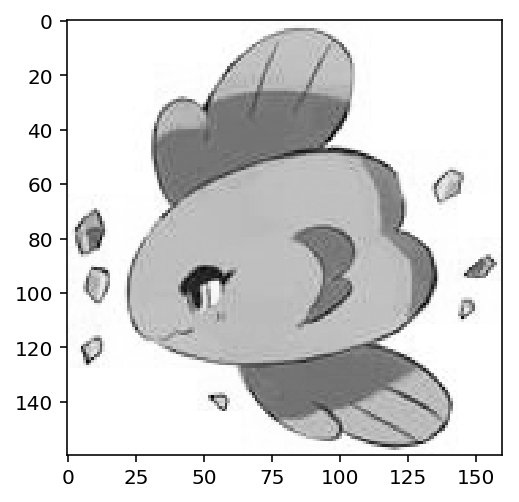

In [11]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape) # make sure tensor is as I expect

# create a dictionary mapping labels to pokemon
pkmnIndDict = trainset.class_to_idx
pkmnIndDict = dict((v,k) for k,v in pkmnIndDict.items()) # flip keys and values
print(pkmnIndDict)

# view the 9th imaage in the batch to verify it is correct
print(pkmnIndDict[labels[9].item()])
plt.imshow(images[9].numpy().squeeze(), cmap='Greys_r')

I finally define my sequential model here. I use a linear neural network with a hard-tanh activation function as I found the best results with it (having tried others like ReLu). For my loss function I use categorical cross-entropy and I use stochastic gradient descent with a learning rate of 0.003 for my optimizer.

In [9]:
images, labels = next(iter(trainloader))
print(images.shape)
images.resize_(images.shape[0], 25600)
print(images.shape) # image tensor has been flattened


model = nn.Sequential(nn.Linear(25600, 128),
                      nn.Hardtanh(-1, 1),
                      nn.Linear(128, 10),
                      nn.LogSoftmax(dim=1))

# loss function
criterion = nn.NLLLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 50
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad() # initialize everything to 0
        output = model(images) # run the sequential model
        loss = criterion(output, labels) # calculate loss
        loss.backward() # backpropagate, changing weights
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")


torch.Size([64, 1, 160, 160])
torch.Size([64, 25600])
Training loss: 2.336560821533203
Training loss: 2.081583523750305
Training loss: 2.0280902862548826
Training loss: 1.950948667526245
Training loss: 1.8899145126342773
Training loss: 1.764774703979492
Training loss: 1.7049599170684815
Training loss: 1.6691673755645753
Training loss: 1.5765065908432008
Training loss: 1.6008654594421388
Training loss: 1.493326687812805
Training loss: 1.4208714485168457
Training loss: 1.3867713451385497
Training loss: 1.3867180824279786
Training loss: 1.331482172012329
Training loss: 1.3246212720870971
Training loss: 1.2635181903839112
Training loss: 1.2843381881713867
Training loss: 1.2587509870529174
Training loss: 1.2090388894081117
Training loss: 1.1270987510681152
Training loss: 1.0993812561035157
Training loss: 1.0881554365158081
Training loss: 1.0692699313163758
Training loss: 1.0123938202857972
Training loss: 0.9788111209869385
Training loss: 0.9745205640792847
Training loss: 0.952486538887024
T

Finally, I visualize the probability of  given image being each Pokémon according to my trained model!


maximum probability: tensor(0.5021)
9: Alomomola
8: Alakazam
7: Aipom
6: Aggron
5: Aerodactyl
4: Aegislash
3: Accelgor
2: Absol
1: Abra
0: Abomasnow


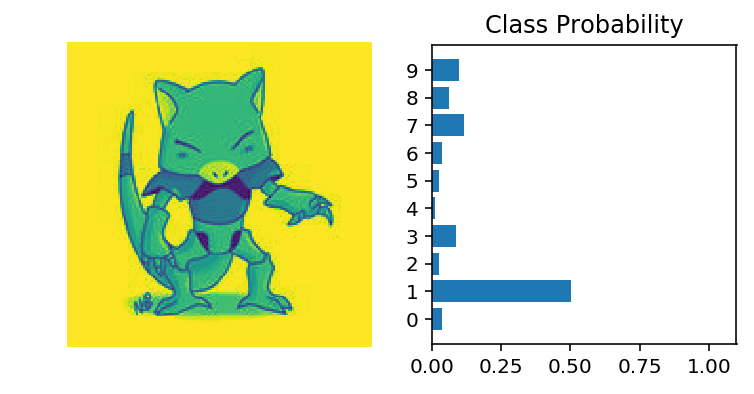

In [10]:
%matplotlib inline
import helper

def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 160, 160).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

images, labels = next(iter(trainloader))

img = images[0].view(1, 25600)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
print("maximum probability:", torch.max(ps))
for i in range(9, -1, -1):
  print(str(i) + ":", pkmnIndDict[i])
view_classify(img.view(1, 160, 160), ps)